In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 6.6 MB/s 
     |████████████████████████████████| 7.6 MB 45.3 MB/s 
     |████████████████████████████████| 163 kB 27.2 MB/s 


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 20.6 MB/s 
     |████████████████████████████████| 212 kB 66.9 MB/s 
     |████████████████████████████████| 182 kB 38.7 MB/s 
     |████████████████████████████████| 132 kB 67.0 MB/s 
     |████████████████████████████████| 127 kB 65.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.4 MB/s 


In [ ]:
import transformers
from datasets import load_dataset
import pandas as pd
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ade_corpus_v2",'Ade_corpus_v2_classification')

Generating train split:   0%|          | 0/23516 [00:00<?, ? examples/s]

Dataset ade_corpus_v2 downloaded and prepared to /root/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0/940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(dataset)

In [ ]:
l = [item for item in dataset["train"] if item['label']== 0]



In [ ]:
l

[{'text': 'Clioquinol intoxication occurring in the treatment of acrodermatitis enteropathica with reference to SMON outside of Japan.',
  'label': 0},
 {'text': '"Retinoic acid syndrome" was prevented with short-time treatment of high dose (4 x 1.5 g/m2) cytarabine.',
  'label': 0},
 {'text': 'BACKGROUND: External beam radiation therapy often is avoided in the treatment of rhabdomyosarcoma (RMS) in young children because of the long-term sequelae.',
  'label': 0},
 {'text': 'Although the enuresis ceased, she developed throbbing headaches, nausea, vomiting, paresthesia, lethargy, fatigue, and altered mental status over the next 7 days.',
  'label': 0},
 {'text': 'A 42-year-old woman had uneventful bilateral laser-assisted subepithelial keratectomy (LASEK) to correct myopia.',
  'label': 0},
 {'text': 'A 16-year-old girl with erosive, polyarticular JRA showed no detectable change in her articular disease following nine exchanges.',
  'label': 0},
 {'text': 'Resection and use of a cycloo

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=250)

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/24 [00:00<?, ?ba/s]

In [ ]:
split_data_set = tokenized_datasets["train"].train_test_split()

In [ ]:
split_data_set

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17637
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5879
    })
})

### Analysis of training and testing datasets

In [ ]:
df_train = pd.DataFrame( split_data_set['train'] )
df_test = pd.DataFrame( split_data_set['test'] )
df_train

KeyboardInterrupt: ignored

In [ ]:
df_train['label'].value_counts()
df_test['label'].value_counts()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=2)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
training_args = TrainingArguments(output_dir="results", evaluation_strategy="epoch",num_train_epochs=10,save_strategy = "epoch")

In [ ]:
metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
train_dataset = split_data_set["train"].shuffle(seed=42)
eval_dataset = split_data_set["test"].shuffle(seed=42)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 17637
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22050


Epoch,Training Loss,Validation Loss,Accuracy
1,0.271300,0.258863,0.937234
2,0.203300,0.241635,0.944208
3,0.175900,0.297246,0.943358
4,0.123600,0.284041,0.949651
5,0.066600,0.308595,0.946249


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5879
  Batch size = 8
Saving model checkpoint to results/checkpoint-2205
Configuration saved in results/checkpoint-2205/config.json
Model weights saved in results/checkpoint-2205/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5879
  Batch size = 8
Saving model checkpoint to results/checkpoint-4410
Configuration saved in results/checkpoint-4410/config.json
Model weights saved in results/checkpoint-4410/pytorch_mode

Epoch,Training Loss,Validation Loss,Accuracy
1,0.271300,0.258863,0.937234
2,0.203300,0.241635,0.944208
3,0.175900,0.297246,0.943358
4,0.123600,0.284041,0.949651
5,0.066600,0.308595,0.946249


KeyboardInterrupt: ignored

In [ ]:
!zip -r '/content/classifier.zip' '/content/results/checkpoint-11025'

  adding: content/results/checkpoint-11025/ (stored 0%)
  adding: content/results/checkpoint-11025/trainer_state.json (deflated 77%)
  adding: content/results/checkpoint-11025/scheduler.pt (deflated 50%)
  adding: content/results/checkpoint-11025/training_args.bin (deflated 48%)
  adding: content/results/checkpoint-11025/rng_state.pth (deflated 27%)
  adding: content/results/checkpoint-11025/pytorch_model.bin (deflated 7%)
  adding: content/results/checkpoint-11025/optimizer.pt (deflated 22%)
  adding: content/results/checkpoint-11025/config.json (deflated 49%)


In [ ]:
model_test = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-11025").to("cuda")

loading configuration file results/checkpoint-11025/config.json
Model config BertConfig {
  "_name_or_path": "results/checkpoint-11025",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file results/checkpoint-11025/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initi

  0%|          | 0/5879 [00:00<?, ?it/s]

In [ ]:
import torch
import torch.nn.functional as F
from sklearn import metrics
from tqdm.auto import tqdm
progress_bar = tqdm(range(len(eval_dataset['text'])))
 
y_preds = []
y_trues = []
for index,val_text in enumerate(eval_dataset['text']):
     encoding = tokenizer([val_text], truncation=True, padding="max_length", max_length=250, return_tensors="pt")
     encoding = {k: v.to(trainer.args.device) for k, v in encoding.items()}
     with torch.no_grad():
       outputs = trainer.model(**encoding)
     logits = outputs.logits 
     prediction = logits.argmax(-1).cpu().numpy()[0]
     
     y_true = eval_dataset['label'][index]
     y_preds.append(prediction)
     y_trues.append(y_true)
     progress_bar.update(1)

  0%|          | 0/5879 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score,f1_score
accuracy_score(y_trues, y_preds)
print(f1_score(y_trues, y_preds, average='micro'))

0.9552645007654363


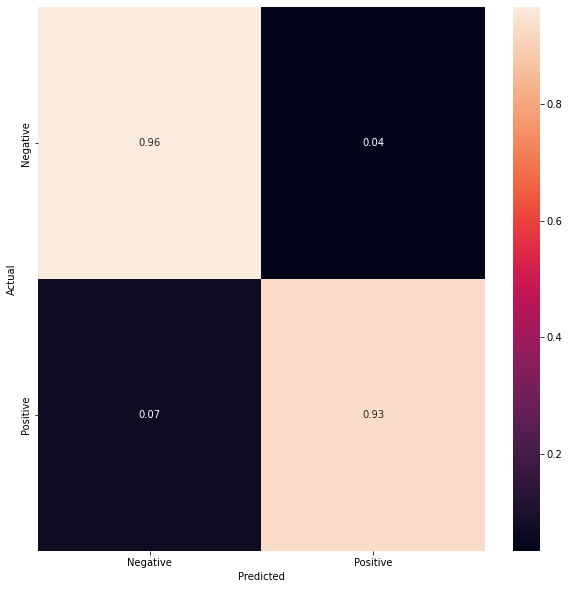

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

cm  = metrics.confusion_matrix(y_trues, y_preds)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
cm

array([[4084,  132],
       [  93, 1570]])

In [ ]:
m = torch.nn.Softmax(dim=1)

def classify_text(string):
  encoding = tokenizer([string], truncation=True, padding="max_length", max_length=250, return_tensors="pt")
  encoding = {k: v.to(trainer.args.device) for k, v in encoding.items()}

  with torch.no_grad():
      outputs = trainer.model(**encoding)
  logits = outputs.logits 
  print(m(logits))
  prediction = logits.argmax(-1).cpu().numpy()[0]

  if prediction == 0:
    relevance = "Non relevant"
  else:
    relevance = "Relevant"
  
  print("Predicted class : {}".format(relevance))


In [ ]:
string = """Paracetamol/acetaminophen is one of the most popular and most commonly used analgesic and antipyretic drugs around the world, available without a prescription, both in mono- and multi-component preparations. It is the drug of choice in patients that cannot be treated with non-steroidal anti-inflammatory drugs (NSAID), such as people with bronchial asthma, peptic ulcer disease, hemophilia, salicylate-sensitized people, children under 12 years of age, pregnant or breastfeeding women. It is recommended as a first-line treatment of pain associated with osteoarthritis. The mechanism of action is complex and includes the effects of both the peripheral (COX inhibition), and central (COX, serotonergic descending neuronal pathway, L-arginine/NO pathway, cannabinoid system) antinociception processes and "redox" mechanism. Paracetamol is well tolerated drug and produces few side effects from the gastrointestinal tract, however, despite that, every year, has seen a steadily increasing number of registered cases of paracetamol-induced liver intoxication all over the world. Given the growing problem of the safety of acetaminophen is questioned the validity of the sale of the drug without a prescription. This work, in conjunction with the latest reports on the mechanism of action of paracetamol, trying to point out that it is not a panacea devoid of side effects, and indeed, especially when is taken regularly and in large doses (> 4 g/day), there is a risk of serious side effects."""

In [ ]:
classify_text(string)

Predicted class : Relevant


In [ ]:
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize
list_sentences = sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
for sentence in list_sentences:
  print("Sentence 1 :",sentence)
  classify_text(sentence)

Sentence 1 : Paracetamol/acetaminophen is one of the most popular and most commonly used analgesic and antipyretic drugs around the world, available without a prescription, both in mono- and multi-component preparations.
tensor([[9.9994e-01, 5.5576e-05]], device='cuda:0')
Predicted class : Non relevant
Sentence 1 : It is the drug of choice in patients that cannot be treated with non-steroidal anti-inflammatory drugs (NSAID), such as people with bronchial asthma, peptic ulcer disease, hemophilia, salicylate-sensitized people, children under 12 years of age, pregnant or breastfeeding women.
tensor([[9.9995e-01, 5.0807e-05]], device='cuda:0')
Predicted class : Non relevant
Sentence 1 : It is recommended as a first-line treatment of pain associated with osteoarthritis.
tensor([[9.9994e-01, 5.5042e-05]], device='cuda:0')
Predicted class : Non relevant
Sentence 1 : The mechanism of action is complex and includes the effects of both the peripheral (COX inhibition), and central (COX, serotoner

In [ ]:
list_sentences = sent_tokenize(string)
string = """Objective: To provide an extensive review of case reports, epidemiological data, and the underlying mechanism of antibiotic-induced skin rash in patients with concurrent infectious mononucleosis (IM).

Data sources: A MEDLINE literature search inclusive of the dates 1946 to June 2016 was performed using the search terms anti-bacterial agents and infectious mononucleosis. EMBASE (1980 to June 2016) was searched using the terms mononucleosis and antibiotic agent and drug eruption. References of all relevant articles were reviewed for additional citations and information.

Study selection and data extraction: We selected English-language, primary literature, review articles, and mechanistic articles that addressed antibiotic-induced skin rash in patients with concurrent IM. We assessed all case reports available for causality utilizing a modified Naranjo nomogram specifically designed for this subject. We assembled the available epidemiological data into tables to identify trends in incidence rates over the years.

Data synthesis: We identified 17 case reports of antibiotic-associated rash in patients with IM. The median Naranjo score was 6 (range = 1 to 8). The top 3 reported drugs were ampicillin, azithromycin, and amoxicillin. Incidence of this adverse effect was higher in the 1960s (55.6%, 45%, and 33%) than in 2013 (33% and 15%). The mechanism most commonly proposed is a transient virus-mediated immune alteration that sets the stage for loss of antigenic tolerance and the development of a reversible, delayed-type hypersensitivity reaction to the antibiotic.

Conclusion: A reassessment of the long-held belief of the high incidence (80%-100%) of antibiotic-induced skin rash in patients with IM seems prudent. Additional studies will be necessary to clarify this issue.

Keywords: adverse drug reactions; antibiotics; infectious disease; viral infections; β-lactams."""

classify_text(string)

tensor([[0.0018, 0.9982]], device='cuda:0')
Predicted class : Relevant


In [ ]:
for index,sentence in enumerate(list_sentences):
  print("Sentence {} :".format(index),sentence)
  classify_text(sentence)

Sentence 0 : Objective: To provide an extensive review of case reports, epidemiological data, and the underlying mechanism of antibiotic-induced skin rash in patients with concurrent infectious mononucleosis (IM).
tensor([[9.9986e-01, 1.3548e-04]], device='cuda:0')
Predicted class : Non relevant
Sentence 1 : Data sources: A MEDLINE literature search inclusive of the dates 1946 to June 2016 was performed using the search terms anti-bacterial agents and infectious mononucleosis.
tensor([[9.9994e-01, 5.5166e-05]], device='cuda:0')
Predicted class : Non relevant
Sentence 2 : EMBASE (1980 to June 2016) was searched using the terms mononucleosis and antibiotic agent and drug eruption.
tensor([[9.9993e-01, 6.5200e-05]], device='cuda:0')
Predicted class : Non relevant
Sentence 3 : References of all relevant articles were reviewed for additional citations and information.
tensor([[9.9994e-01, 6.0670e-05]], device='cuda:0')
Predicted class : Non relevant
Sentence 4 : Study selection and data ext